In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# from lstm_model import RNN_LoadForecastser
from lstm_model_2 import LoadForecastser
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [2]:
# 超参数
type_num = 10
batch_size = 24
n_features = 27
n_hidden = 128
seq_len = 96 * 7
n_layers = 2
out_features = 96
do = 0.2
lr = 0.0005
wd = 0.01
n_epochs = 150

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [131]:
# 导入要inverse transform的df数据,生成userID和coName的键值对
csv_path = './data/type_%s_csv_after_anomaly_detection/' % type_num
file_list = os.listdir(csv_path)
user_id_df_dict = {}
user_id_co_name_dict = {}
for i in range(len(file_list)):
    file = file_list[i]
    coName, userID = file[:-4].split('_')
    print(coName)
    df = pd.read_csv(csv_path + file)
    user_id_df_dict[userID] = df
    user_id_co_name_dict[userID] = coName

user_id_list = list(user_id_co_name_dict.keys())


南京年余冷冻食品有限公司
南京年吉冷冻食品有限公司
通用磨坊食品(南京)有限公司
食品行业
南京大旺食品有限公司
南京紫泉饮料工业有限公司
南京百事可乐饮料有限公司
南京顶益食品有限公司
南京冠生园食品厂集团有限公司


In [137]:
k = 7
userID = user_id_list[k]
coName = user_id_co_name_dict[userID]
print(coName)
user_df = user_id_df_dict[userID].copy()
col_load = user_df.loc[:, 'load'].values.reshape(-1, 1)

# 提取load的最大最小值
scaler = MinMaxScaler()
scaler = scaler.fit(col_load)
# del user_df
# del col_load
# del user_id_df_dict

南京顶益食品有限公司


In [138]:
# 导入训练集和测试集

npy_path = './output/train_test/type%s/%s_%s/' % (type_num, coName, userID)

date_range = 365

if date_range == 90:
    test_x = np.load(npy_path + 'test_x_days_90.npy')
    test_y = np.load(npy_path + 'test_y_days_90.npy')
elif date_range == 365:
    test_x = np.load(npy_path + 'test_x_days_365.npy')
    test_y = np.load(npy_path + 'test_y_days_365.npy')



# numpy to tensor
test_x = torch.from_numpy(test_x).type(torch.Tensor)
test_y = torch.from_numpy(test_y).type(torch.Tensor)

model = LoadForecastser(n_features=n_features, n_hidden=n_hidden, seq_len=seq_len,
                        n_layers=n_layers, out_features=out_features,
                        do=do, device=device).to(device)
path = '/home/gavin/Documents/GitHub/FedML/fedml_experiments/standalone/fedavg/'
model.load_state_dict(torch.load(path + 'temp-20210428-030246.pth'))
model.eval()

# 模型用于测试集
test_x = test_x.to(device)
test_y_pred = model(test_x).to(device)

test_y_pred = test_y_pred.detach().cpu().numpy()

print(test_x.shape)

test_y = scaler.inverse_transform(test_y)
print(test_y.shape)

test_y_pred = scaler.inverse_transform(test_y_pred)
print(test_y_pred.shape)

testScore = math.sqrt(mean_squared_error(test_y[:, 0], test_y_pred[:, 0]))
print('Test Score: %.2f RMSE' % testScore)

torch.Size([2209, 672, 27])
(2209, 96)
(2209, 96)
Test Score: 469.19 RMSE


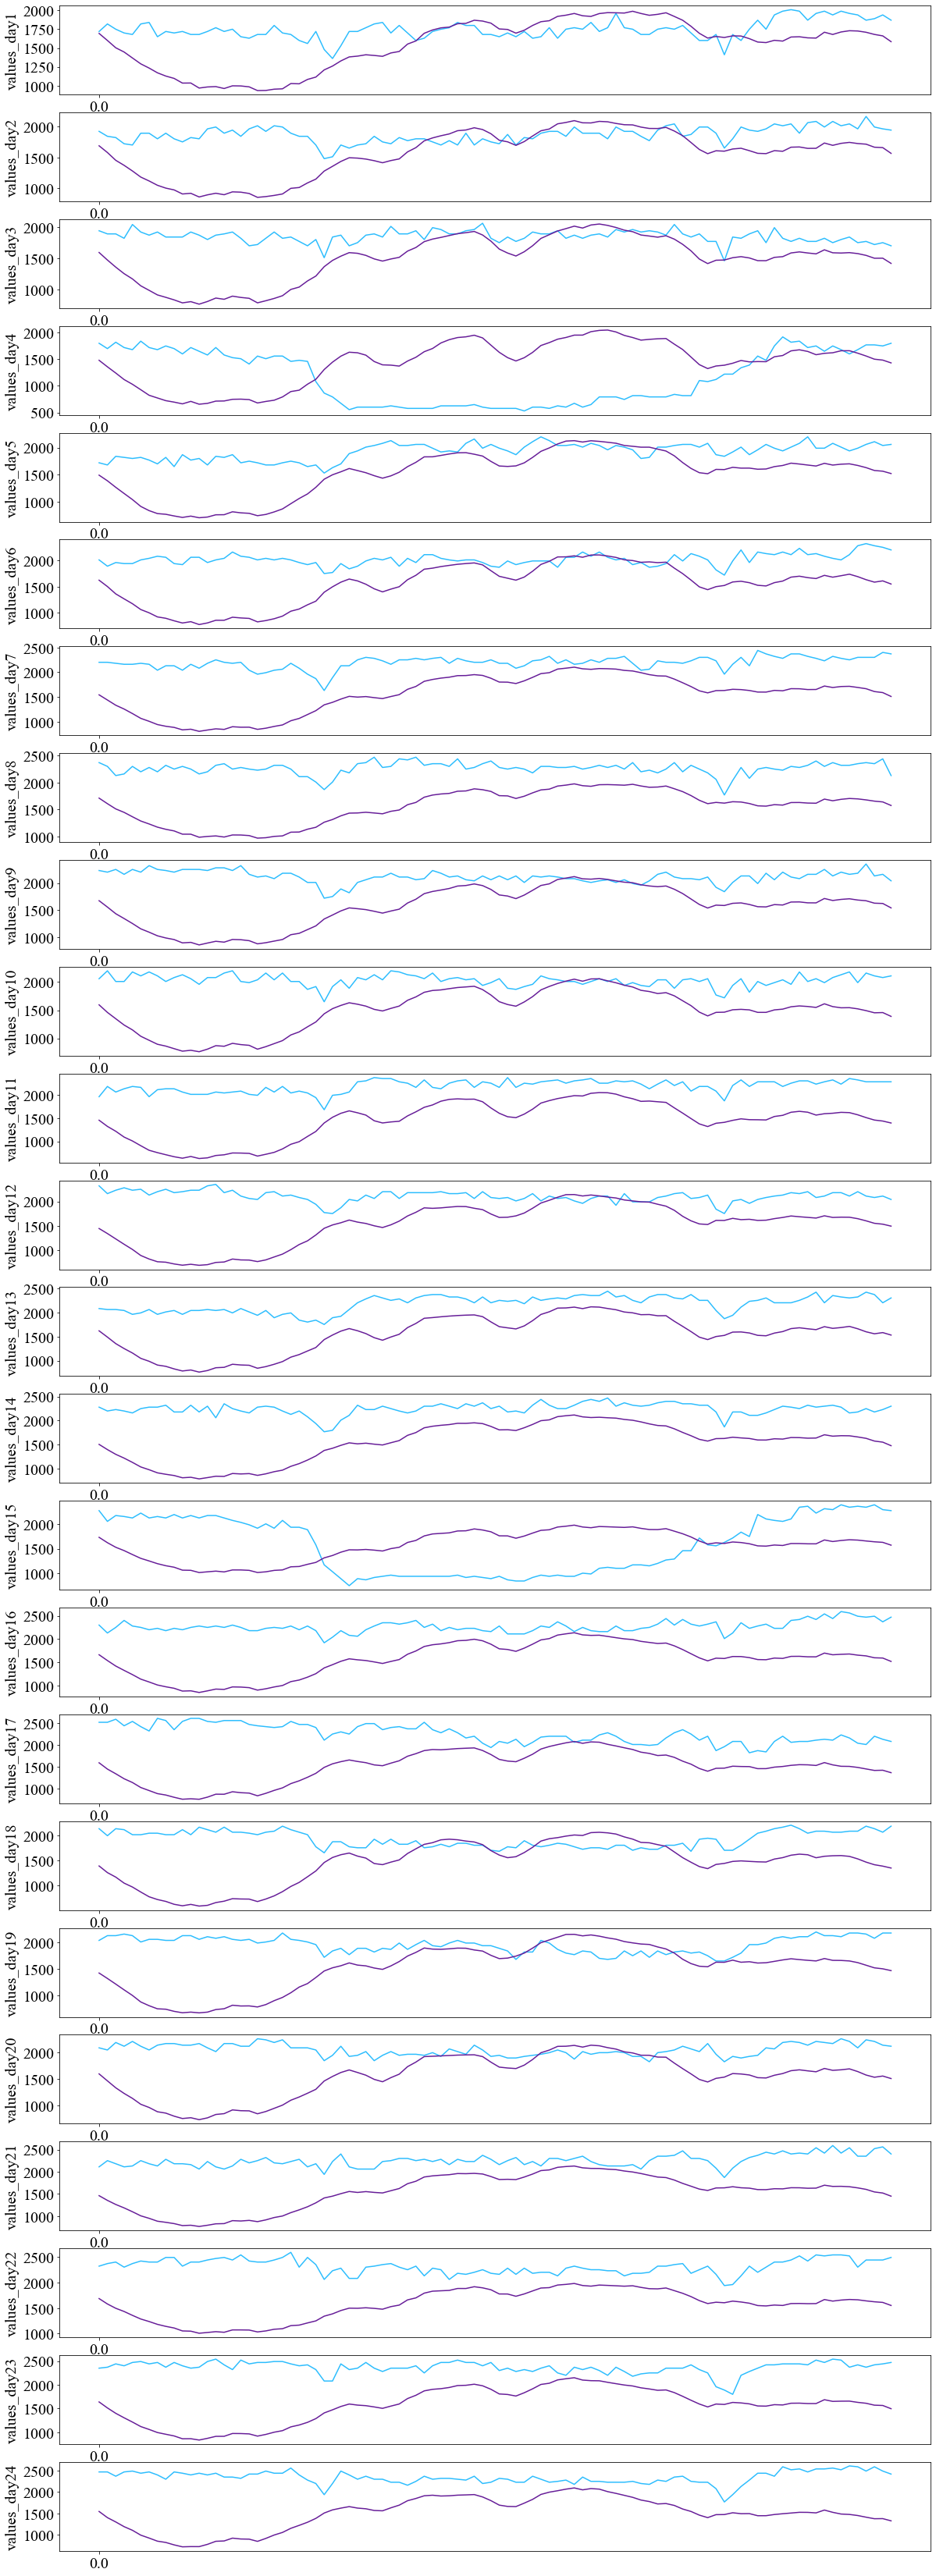

In [139]:
font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 20,
       }
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
n_fig = 24
fig = plt.figure()
fig.set_size_inches(20, 60, forward=True)
for i in range(n_fig):
    j = 96 * i
    ax = plt.subplot(n_fig, 1, i+1)
    y1 = test_y[j: j+96: 96, :]
    y1 = y1.reshape(y1.shape[0] * y1.shape[1])
    y2 = test_y_pred[j: j+96: 96, :]
    y2 = y2.reshape(y2.shape[0] * y2.shape[1])
    x = range(0, y1.shape[0])
    ax.plot(x, y1, color_list[0])
    ax.plot(x, y2, color_list[-1])
    plt.xticks(font=font)
    plt.yticks(font=font)
    ax.set_ylabel('values_day%s' % (i+1), font=font)
    ax.set_xticks(np.arange(0, y1.shape[0], 96))
    ax.set_xticklabels(np.arange(0, y1.shape[0]/96))

path = './output/img/testing/type%s/' % type_num
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(path + '/forward_per_day_%d_k_%d.jpg' % (int(testScore), k))
plt.show()

(2016,)
(2016,)


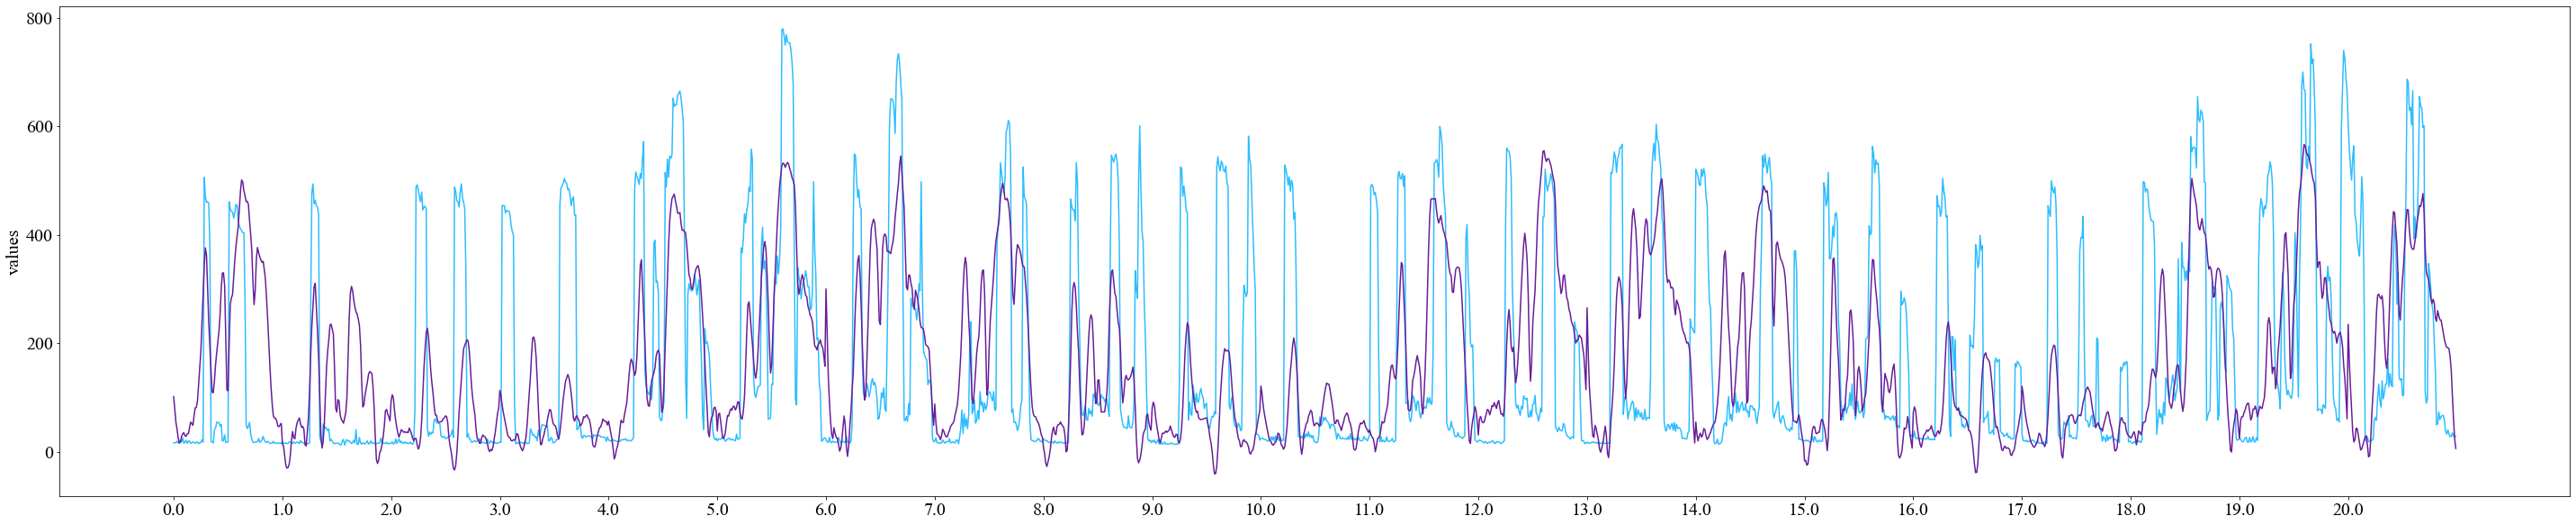

In [22]:
i = 0
y1 = test_y[i::96, :]
y1 = y1.reshape(y1.shape[0] * y1.shape[1])
print(y1.shape)
y2 = test_y_pred[i::96, :]
y2 = y2.reshape(y2.shape[0] * y2.shape[1])
print(y2.shape)

font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 20,
       }
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]

fig, ax = plt.subplots(figsize=(50, 10))
x = range(0, y1.shape[0])
ax.plot(x, y1, color_list[0])
ax.plot(x, y2, color_list[-1])
plt.xticks(font=font)
plt.yticks(font=font)
ax.set_ylabel('values', font=font)
ax.set_xticks(np.arange(0, y1.shape[0], 96))
ax.set_xticklabels(np.arange(0, y1.shape[0]/96))
plt.savefig('./output/img/forward_all_days_%d_k_%d.jpg' % (int(testScore), k))
plt.show()